# Import Libraries

In [1]:
# Keras
import tensorflow as tf
from keras.layers import Dense, LSTM, Reshape
from keras.layers import Input, Dropout, Activation, BatchNormalization
from keras.callbacks import (EarlyStopping,
                             ModelCheckpoint)
from keras import losses, models
from keras.activations import  softmax
from keras.layers import (Convolution2D, BatchNormalization, Dropout,
                           MaxPool2D, Activation, Input, Dense)
from keras_self_attention import SeqSelfAttention
from keras.utils import to_categorical
#tf.keras.layers.Attention
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import pickle
import IPython.display as ipd  # To play sound in the notebook
import warnings

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
print("Executed")

2024-05-04 04:54:38.572971: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 04:54:38.698217: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 04:54:38.975336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 04:54:43.497000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Executed


In [2]:

#save dataset file name as below 
file_name = "data/ravdess/audio_speech_actors_01-24"
file_nameS = "data/savee"
file_nameT = "data/tess"
#save path of dataset in to a variable
Ravdess = os.path.join(os.getcwd(),file_name)
Savee = os.path.join(os.getcwd(),file_nameS)
Tess = os.path.join(os.getcwd(),file_nameT)

print(Ravdess)
print("Executed Successfully")

/home/metgoog/Desktop/wanderer-ser/data/ravdess/audio_speech_actors_01-24
Executed Successfully


In [3]:
# ravdess_directory_list stores the list of present in the provided path
# os.listdir helps in storing the list of data
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
#file_gender = []
source = []
for dir in ravdess_directory_list:
    # For different actors in our directory
    # For different audio clips in folders
    actor = os.listdir(Ravdess + '/'+ dir)
    for file in actor:
        # split '.' and select the first then add '_' and select third
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + '/' + dir + '/' + file)
        source.append('RAVDE')
emotion_df = pd.DataFrame(file_emotion, columns=['label'])
# dataframe for path of files.
# create a data frame with each row containing file_path list contents and its header name Path
path_df = pd.DataFrame(file_path, columns=['path'])
source = pd.DataFrame(source, columns=['source'])
# aoth and emotion concatenation
Ravdess_df = pd.concat([emotion_df, source, path_df], axis=1)
# conversion to actual emotions.
Ravdess_df.label.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []
source = []
for dir in tess_directory_list:
    directories = os.listdir(Tess +'/'+ dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
            # whatever the string is becomes the emotion
        file_path.append(Tess + '/'+ dir + '/' + file)
        source.append('TESS')   
emotion_df = pd.DataFrame(file_emotion, columns=['label'])
path_df = pd.DataFrame(file_path, columns=['path'])
#Concatenate Emotion and Path
source_df = pd.DataFrame(source, columns=['source'])
Tess_df = pd.concat([emotion_df, source_df, path_df], axis=1)
Tess_df.head()



savee_directory_list = os.listdir(Savee)
file_emotion = []
file_path = []
source = []
for file in savee_directory_list:
    file_path.append(Savee + '/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
    source.append('SAVEE')
emotion_df = pd.DataFrame(file_emotion, columns=['label'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
source_df = pd.DataFrame(source, columns=['source'])
Savee_df = pd.concat([emotion_df, source_df, path_df], axis=1)
Savee_df.head()

# Final dataset by concatenating all 3
data_path = pd.concat([Ravdess_df, Tess_df, Savee_df], axis = 0, ignore_index = True)
data_path.to_csv("data.csv",index=True)
ref = data_path.copy()
ref

print("data.csv created successfully referring the paths")

data.csv created successfully referring the paths


    # Function to augment the data

In [4]:
def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    

def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

print("Augmentation function setup successfully")

Augmentation function setup successfully


# Data Preparation

In [13]:
def CNN_1D_prepare_data(ref, n_mfcc, audio_duration, aug):
    if aug == 1:
        df = pd.DataFrame(columns=['feature'])
        df_noise = pd.DataFrame(columns=['feature'])
        df_speedpitch = pd.DataFrame(columns=['feature'])
        cnt = 0
        for i in tqdm(ref.path):

            X, sample_rate = librosa.load(i
                                          , res_type='kaiser_fast'
                                          ,duration=audio_duration
                                          ,sr=44100
                                          ,offset=0.5
                                         )

            mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                                sr=np.array(sample_rate), 
                                                n_mfcc=n_mfcc),
                            axis=0)

            df.loc[cnt] = [mfccs]  
            aug = noise(X)
            aug = np.mean(librosa.feature.mfcc(y=aug, 
                                            sr=np.array(sample_rate), 
                                            n_mfcc=n_mfcc),    
                          axis=0)
            df_noise.loc[cnt] = [aug]

            aug = speedNpitch(X)
            aug = np.mean(librosa.feature.mfcc(y=aug, 
                                            sr=np.array(sample_rate), 
                                            n_mfcc=n_mfcc),    
                          axis=0)
            df_speedpitch.loc[cnt] = [aug]   

            cnt += 1

        df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
        df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
        df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
        print(df.shape,df_noise.shape,df_speedpitch.shape)
        df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
        df=df.fillna(0)
        del df_noise, df_speedpitch

        return df
        

    else:
        df = pd.DataFrame(columns=['feature'])
        counter=0
        for path in tqdm(ref.path):
            X, sample_rate = librosa.load(path
                                          , res_type='kaiser_fast'
                                          ,duration=audio_duration
                                          ,sr=44100
                                          ,offset=0.5
                                         )
            sample_rate = np.array(sample_rate)

            mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                                sr=sample_rate, 
                                                n_mfcc=n_mfcc),
                            axis=0)
            df.loc[counter] = [mfccs]
            counter=counter+1   

        df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
        df = df.fillna(0)
        return df



# Funtion to extract as matrix for 2-D  
def CNN_2D_prepare_data(df, n, aug, mfcc):
    
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(y=data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X

def CNN_2D_prepare_data2(df, n, aug, mfcc):
    
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        if aug == 1:
            data = noise(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)

            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X
   
    
def data_normalization(X_train, X_test, X_val):
    # Lts do data normalization 
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train_norm = (X_train - mean)/std
    X_test_norm = (X_test - mean)/std
    X_val_norm = (X_val - mean)/std
    
    return X_train_norm, X_test_norm, X_val_norm

def np_array_conversation(X_train, y_train, X_test, y_test, X_val, y_val):
    # Lets few preparation steps to get it into the correct format for Keras 

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    #print(X_train.shape)
    
    return X_train, y_train, X_test, y_test, X_val, y_val

print("Preprocessed")


Preprocessed


# Function Related To Results

In [6]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        #heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        heatmap = sns.heatmap(df_cm, annot=True, fmt='.2%')

    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class get_results:

    def __init__(self, model_history, model ,X_test_norm, y_test_cat, labels):
        self.model_history = model_history
        self.model = model
        self.X_test_norm = X_test_norm
        self.y_test_cat = y_test_cat             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        plt.plot(model_history.history['acc'])
        plt.plot(model_history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()


    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = tf.keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
        test_loss, test_acc = model.evaluate(X_test_norm, y_test_cat, verbose=0)
        print("Test Accuracy: ",test_acc)
        print("Test loss: ",test_loss) 
        score = model.evaluate(X_test_norm, y_test_cat, verbose=1)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
            

    def confusion_results(self, X_test_norm, y_test_cat, labels, model):
        preds = model.predict(X_test_norm, 
                              batch_size=16, 
                              verbose=1)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))
        preds = pd.DataFrame({'predictedvalues': preds})# new temp code
        
        actual = y_test_cat.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        actual = pd.DataFrame({'actualvalues': actual}) ## new temp code
        
        finaldf = actual.join(preds)
        print(finaldf[170:180])     
        
        # Make a disk copy of predictions
        finaldf.to_csv('Predictions.csv', index=False)
        print(finaldf.groupby('predictedvalues').count())
        
        classes = labels
        classes.sort()    
        cm = confusion_matrix(actual, preds)
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print_confusion_matrix(cmn, class_names = classes)

        return finaldf
    
print("Result functions created")    

Result functions created


# Dataset Visualization

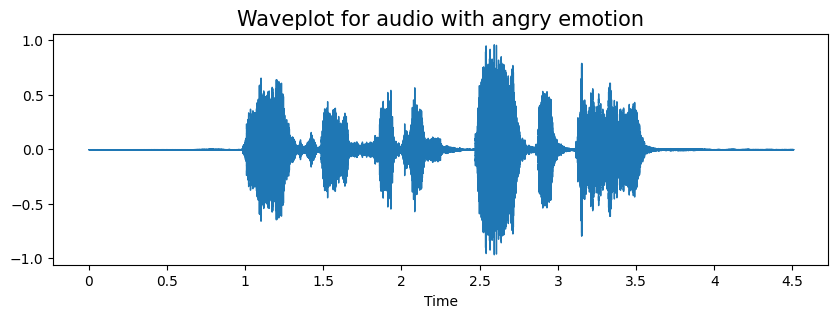

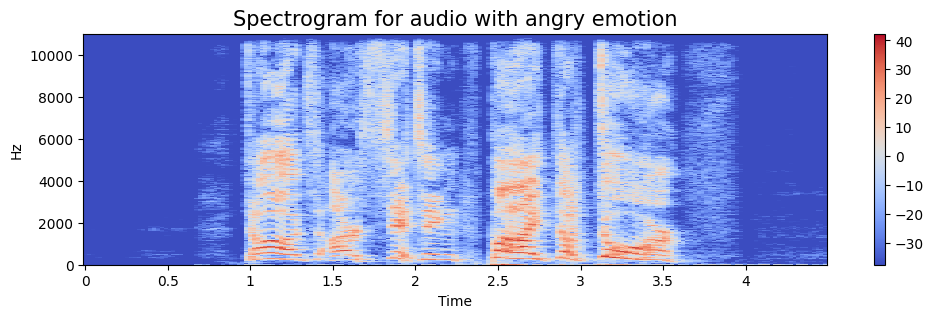

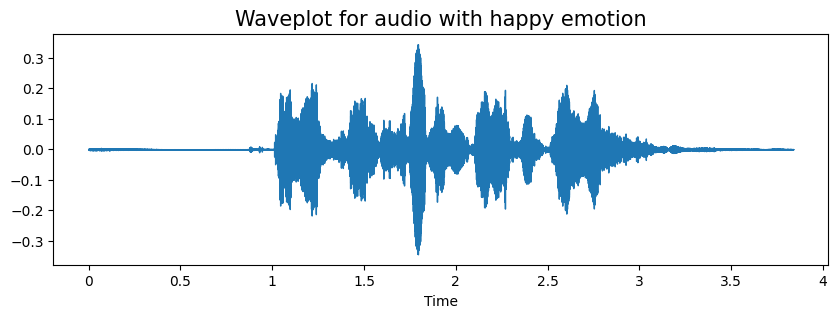

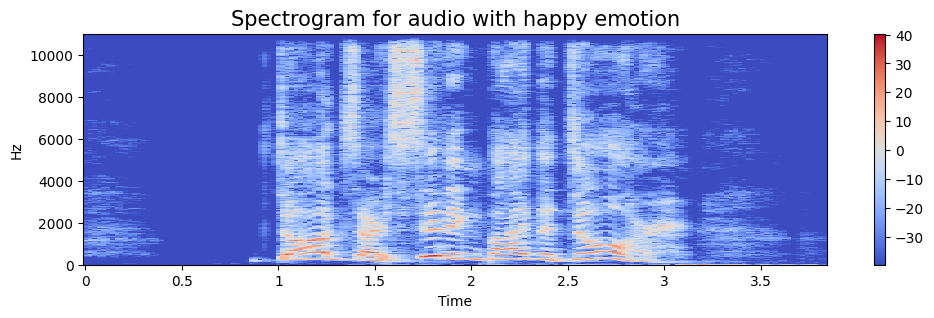

In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    # Python abs() function is used to return the absolute value of a number, i.e., it will remove the negative sign of the number.  
    # librosa.amplitude_to_db Convert an amplitude spectrogram to dB-scaled spectrogram.
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

emotion='angry'
path = np.array(ref.path[data_path.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

emotion='happy'
path = np.array(ref.path[data_path.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# 2D CNN MFCC with Augmentation

In [14]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
aug = 0
mfcc = CNN_2D_prepare_data(ref, n_mfcc, aug, mfcc = 1)    # mfcc = 0  means MFCC conversion will be used

100%|██████████| 4720/4720 [07:59<00:00,  9.84it/s]


In [19]:
import pandas as pd
import numpy as np

# Assuming ref is your DataFrame and mfcc is calculated somewhere

sampling_rate = 44100
audio_duration = 2.5
n_mfcc = 30

# Assuming these functions generate mfcc_aug and mfcc_aug2
mfcc_aug = CNN_2D_prepare_data(ref, n=n_mfcc, aug=1, mfcc=1)
mfcc_aug = np.append(mfcc_aug, mfcc, axis=0)

label1 = pd.DataFrame(ref.label)
label2 = pd.DataFrame(ref.label)

# Correcting the concatenation of label1 and label2
result = pd.concat([label1, label2], ignore_index=True, sort=True)
result = result.reset_index()
result = result.drop(['index'], axis=1)

mfcc_aug2 = CNN_2D_prepare_data2(ref, n=n_mfcc, aug=1, mfcc=1)
mfcc_aug2 = np.append(mfcc_aug2, mfcc_aug, axis=0)

label2 = pd.DataFrame(ref.label)

# Correcting the concatenation of result and label2
result2 = pd.concat([result, label2], ignore_index=True, sort=True)
result2 = result2.reset_index()
result2 = result2.drop(['index'], axis=1)


100%|██████████| 4720/4720 [07:56<00:00,  9.91it/s]


In [18]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_aug = CNN_2D_prepare_data(ref, n = n_mfcc, aug = 1, mfcc = 1)
mfcc_aug = np.append(mfcc_aug, mfcc, axis=0)
label1 = pd.DataFrame(ref.label)
label2 = pd.DataFrame(ref.label)
result = label1.append(label2,sort=True)
result = result.reset_index()
result = result.drop(['index'], axis=1)
mfcc_aug2 = CNN_2D_prepare_data2(ref, n = n_mfcc, aug = 1, mfcc = 1)
mfcc_aug2 = np.append(mfcc_aug2, mfcc_aug, axis=0)
label2 = pd.DataFrame(ref.label)
result2 = result.append(label2,sort=True)
result2 = result2.reset_index()
result2 = result2.drop(['index'], axis=1)

  0%|          | 0/4720 [00:00<?, ?it/s]

100%|██████████| 4720/4720 [08:17<00:00,  9.49it/s]


AttributeError: 'DataFrame' object has no attribute 'append'

In [20]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug2
                                                    , result2
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

X_train, X_val, y_train, y_val = train_test_split(X_train
                                                  , y_train
                                                  , test_size=0.25
                                                  , shuffle=True
                                                  , random_state=42
                                                 )

2D CNN LSTM with Self-Attention Model

(7965, 30, 216, 1)
['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 216, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 216, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 216, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 30, 216, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 108, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 108, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 15, 108, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 54, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 54, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 7, 54, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 27, 128)     │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 27, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 3, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 13, 32)         │        20,60

 Total params: 698,313 (2.66 MB)

 Trainable params: 697,161 (2.66 MB)

 Non-trainable params: 1,152 (4.50 KB)

Save model and weights at /home/metgoog/Desktop/wanderer-ser/saved_models2/best_model.keras 


2024-05-04 06:29:59.984990: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 206452800 exceeds 10% of free system memory.


Epoch 1/70
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.3161 - loss: 1.8535
Epoch 1: val_acc improved from -inf to 0.30659, saving model to /home/metgoog/Desktop/wanderer-ser/saved_models2/best_model.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 595s 1s/step - acc: 0.3163 - loss: 1.8531 - val_acc: 0.3066 - val_loss: 1.7569
Epoch 2/70
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.5758 - loss: 1.2802
Epoch 2: val_acc improved from 0.30659 to 0.62599, saving model to /home/metgoog/Desktop/wanderer-ser/saved_models2/best_model.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 542s 1s/step - acc: 0.5759 - loss: 1.2800 - val_acc: 0.6260 - val_loss: 1.0896
Epoch 3/70
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - acc: 0.6452 - loss: 1.0382
Epoch 3: val_acc improved from 0.62599 to 0.68060, saving model to /home/metgoog/Desktop/wanderer-ser/saved_models2/best_model.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 531s 1s/step - acc: 0.6452 - loss: 1.0381 - val_acc: 0.6806 - val_loss: 0.9193
Epoch 4/70
498/498 ━━━━━━━━━━━━━━━━━━

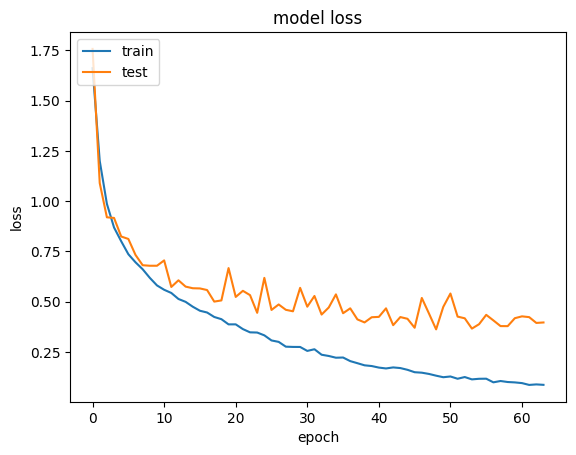

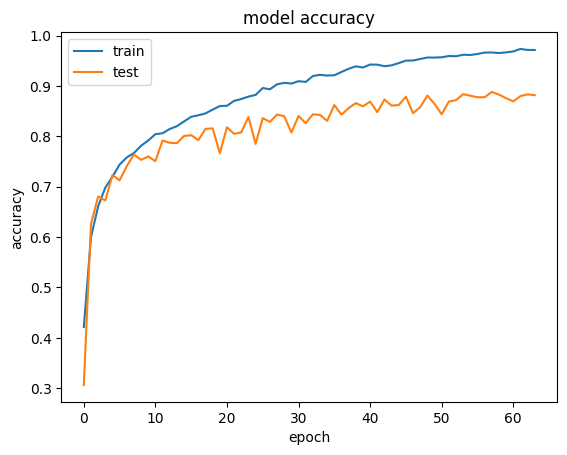

Loaded model from disk


2024-05-04 12:32:06.757912: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 91756800 exceeds 10% of free system memory.


Test Accuracy:  0.8901129961013794
Test loss:  0.34352996945381165


2024-05-04 12:32:33.177475: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 91756800 exceeds 10% of free system memory.


111/111 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - acc: 0.8888 - loss: 0.3424
compile_metrics: 89.01%


2024-05-04 12:32:57.012369: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 91756800 exceeds 10% of free system memory.


222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step
    actualvalues predictedvalues
170          sad             sad
171     surprise        surprise
172        happy           happy
173        angry           angry
174          sad           happy
175      neutral         neutral
176      disgust         disgust
177     surprise        surprise
178         fear            fear
179      neutral         neutral
                 actualvalues
predictedvalues              
angry                     497
calm                      161
disgust                   487
fear                      508
happy                     522
neutral                   449
sad                       425
surprise                  491
              precision    recall  f1-score   support

       angry       0.91      0.94      0.92       484
        calm       0.74      0.88      0.80       135
     disgust       0.94      0.89      0.92       513
        fear       0.85      0.90      0.88       479
       happy       0.8

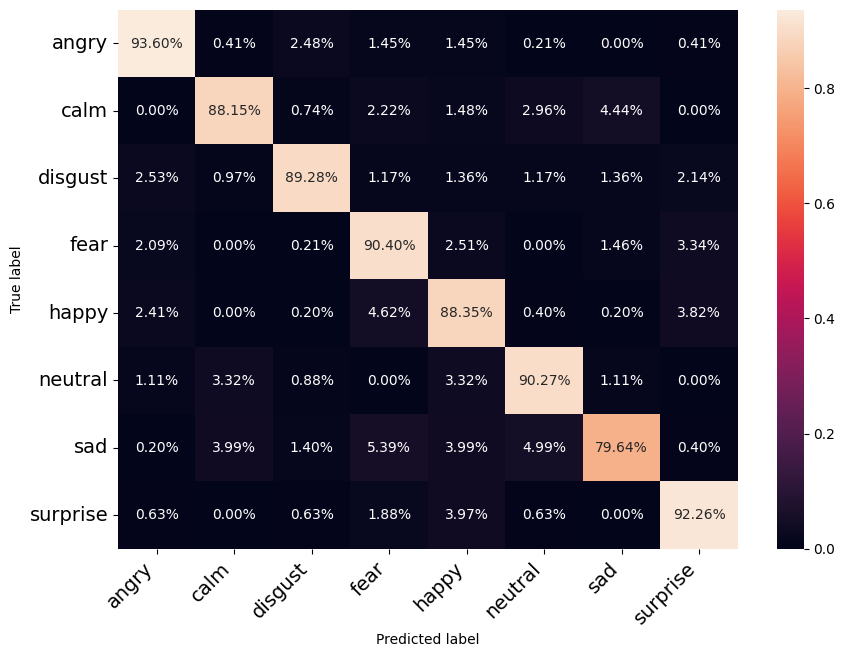

In [23]:
def get_2d_conv_LSTM_atten_model(n):
    ''' Creation of CNN2D + LSTM + Attention Layer '''
    nclass = 8
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(64, (3,3), strides=(1, 1), padding="same")(inp)    #(4,10)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(128, (3,3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(256, (3,3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(128, (3,3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Reshape((-1, 128))(x)
    #LSTM
    x = LSTM(32, return_sequences=True)(x)
    x = SeqSelfAttention(attention_activation ='tanh')(x)
    x = LSTM(32, return_sequences=False)(x)
    
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


# Normalization as per the standard NN process
X_train_norm, X_test_norm, X_val_norm = data_normalization(X_train, X_test, X_val)

# one hot encode the target 
lb = LabelEncoder()
y_train_cat = to_categorical(lb.fit_transform(y_train))    # for GPU
y_test_cat = to_categorical(lb.fit_transform(y_test))      # for GPU
y_val_cat = to_categorical(lb.fit_transform(y_val))        # for GPU


print(X_train.shape)
print(lb.classes_)

model = get_2d_conv_LSTM_atten_model(n_mfcc)
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)


# save_dir = "/home/metgoog/Desktop/wanderer-ser/saved_models2"

model_name = 'best_model.h5'
model_name = "best_model.keras"  # Modify this to change the model name if needed
save_dir = os.path.join(os.getcwd(), 'saved_models2')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
print('Save model and weights at %s ' % model_path)

mc = ModelCheckpoint(model_path, monitor='val_acc', mode='max', verbose=1, 
                     save_best_only=True)
model_history = model.fit(X_train_norm, y_train_cat, validation_data=(X_val_norm, y_val_cat), batch_size=16,
                          verbose = 1, epochs=70, callbacks=[es, mc])

results = get_results(model_history,model,X_test_norm,y_test_cat, ref.label.unique())
results.create_plot(model_history)

model_json = model.to_json()
with open("model_json2.json", "w") as json_file:
    json_file.write(model_json)

# loading json and model architecture 
json_file = open('model_json2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
from keras.models import model_from_json # type: ignore
loaded_model = model_from_json(loaded_model_json, custom_objects={'SeqSelfAttention': SeqSelfAttention})

# load weights into new model
loaded_model.load_weights(model_path)#("saved_models/best_model.h5")
print("Loaded model from disk")

results.create_results(loaded_model)
finaldf = results.confusion_results(X_test_norm,y_test_cat, ref.label.unique(), loaded_model)

# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))